In [1]:
import json
import os
import sys
from dataclasses import dataclass
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import wandb
from dotenv import load_dotenv
from IPython.display import display

sys.path.append(os.path.abspath("../.."))

import src.utils.hill_climbing as hc

## Config

In [2]:
load_dotenv(dotenv_path="../../.env")


@dataclass
class Config:
    data_id: str = "058"
    level: str = "l2"


cfg = Config()
feature_dir = Path(f"../../artifacts/features/{cfg.data_id}")
with open(feature_dir / "meta.json", "r") as f:
    meta = json.load(f)

train_paths = meta["train_paths"]
test_paths = meta["test_paths"]

run_id = Path(f"hc-{cfg.data_id}")
run_dir = "../../runs" / run_id
run_dir.mkdir(parents=True, exist_ok=True)

## Hill Climbing

In [3]:
result = hc.hill_climbing_auc(
    train_paths,
    test_paths
)

0 We begin with best single model AUC 0.97655 from lgbm-057-trl21-5fold-s42
New best score: 0.97663
adding: mlp-057-trl0-5fold-s42
with weight: 0.180

New best score: 0.97668
adding: xgb-057-trl5-5fold-s42
with weight: 0.360

=> We reached tolerance 1e-05


## Check and Save Result

,model,weight
0,lgbm-057-trl21-5fold-s42,0.5248
1,xgb-057-trl5-5fold-s42,0.3600
2,mlp-057-trl0-5fold-s42,0.1152


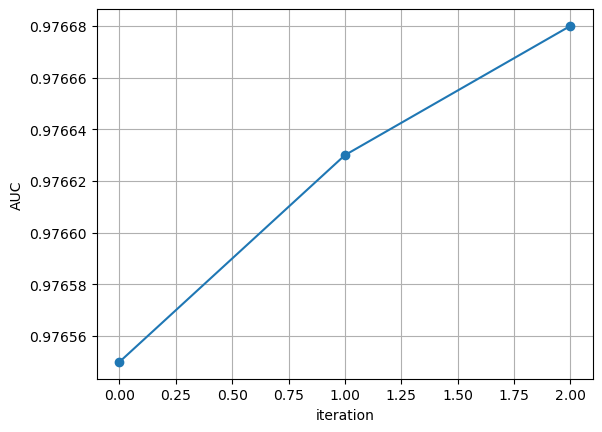

In [4]:
ax = result["history_df"].plot(x="iteration", y="score", marker="o", legend=False)
ax.set_ylabel("AUC")
ax.grid(True)
ax.figure.savefig(run_dir / "progression.png", dpi=300, bbox_inches="tight")

# 重みトップを見る
wdf = pd.DataFrame(list(result["weights"].items()), columns=["model", "weight"])\
        .sort_values("weight", ascending=False).reset_index(drop=True)
display(wdf.head(20))

## WandB

In [5]:
wandb_project = os.environ.get("COMPETITION_NAME")
wandb.login(key=os.environ.get("WANDB_API_KEY"))

run = wandb.init(
    project=wandb_project,
    group=f"hc-{cfg.data_id}",
    name=cfg.data_id,
    job_type="cv_training",
    tags=["hc", cfg.level],
    config={
        "data_id": cfg.data_id
    },
    dir="../../artifacts"
)
run.summary["weights"] = result["weights"]   # dictをそのまま
run.summary["auc_oof"] = float(result["history_df"]["score"].max())
wandb.log({"progression": wandb.Image(run_dir / "progression.png")})
run.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/hanse/.netrc
wandb: Currently logged in as: kaitookano (kaitookano-waseda-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


auc_oof,0.97668


## Save manifest, OOF, and Test Pred

In [6]:
manifest = {
    "run_id": str(run_id),
    "wandb_id": run.id,
    "wandb_url": run.url,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model_name": "hc",
    "data_id": cfg.data_id,
    "feature_dir": str(feature_dir.resolve()),
    "run_dir": str(run_dir.resolve()),
    "cv_score": float(result["history_df"]["score"].max()),
    "weights": result["weights"],
    "submission": {
        "competition": None,
        "ref": None,
        "file": None,
        "public_score": None,
        "private_score": None,
        "submitted_at": None
    }
}

with open(run_dir / "manifest.json", "w") as f:
    json.dump(manifest, f, indent=4)

print("manifest saved", run_dir / "manifest.json")

# oof and test pred
np.save(run_dir / "oof.npy", result["oof_pred"])
np.save(run_dir / "test.npy", result["test_pred"])

print(f"oof and test preds saved successfully in:\n{run_dir}")

manifest saved ../../runs/hc-058/manifest.json
oof and test preds saved successfully in:
../../runs/hc-058
